In [28]:
# ============================================================================
# Visualizations of Mongo Queries
# ============================================================================

# Import libraries
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [29]:
# ============================================================================
# Connect to MONGODB
# ============================================================================

client = MongoClient('mongodb://localhost:27017/')
db = client['hyrox_db']
collection = db['athletes']

print(" Succesfull connection to MongoDB")

 Succesfull connection to MongoDB


✓ Retrieved 92,013 records
  gender  total_minutes
0   male      59.116667
1   male      59.450000
2   male      60.366667
3   male      63.216667
4   male      64.000000


<Figure size 1000x600 with 0 Axes>

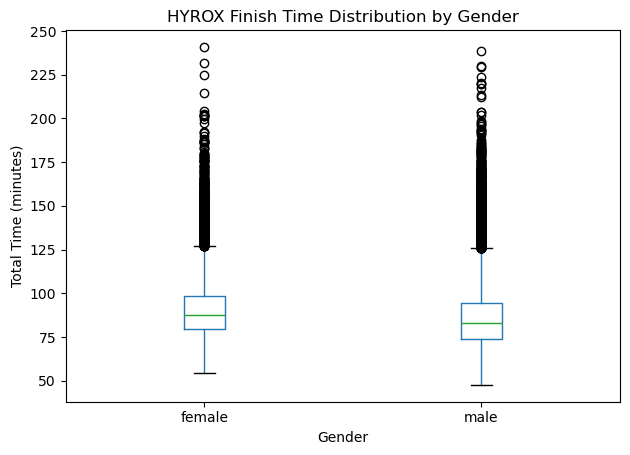

✓ Saved: boxplot_time_by_gender.png


In [30]:
# ============================================================================
# Promedio de tiempos totales por genero
# ============================================================================

pipeline = [
    {"$match": {"performance.is_valid": True}},
    {"$project": {
        "_id": 0,
        "gender": "$athlete.gender",
        "total_minutes": {"$divide": ["$performance.total_seconds", 60]}
    }}
]

results = list(collection.aggregate(pipeline))
df = pd.DataFrame(results)

print(f"✓ Retrieved {len(df):,} records")
print(df.head())

# ============================================
# BOXPLOT: Total time by gender
# ============================================
plt.figure(figsize=(10, 6))

# Create boxplot
df.boxplot(column='total_minutes', by='gender', grid=False)

plt.xlabel('Gender')
plt.ylabel('Total Time (minutes)')
plt.title('HYROX Finish Time Distribution by Gender')
plt.suptitle('')  # Remove automatic title
plt.tight_layout()
plt.savefig('boxplot_time_by_gender.png', dpi=150)
plt.show()

print("✓ Saved: boxplot_time_by_gender.png")

✓ Data processed
  division  gender  rank nationality total_time  total_minutes
0  doubles  female     1     Unknown    0:54:42      54.700000
1  doubles  female     2     Unknown    0:54:42      54.700000
2  doubles  female     3     Unknown    0:55:13      55.216667
3  doubles    male     1     Unknown    0:48:48      48.800000
4  doubles    male     2     Unknown    0:48:52      48.866667
5  doubles    male     3     Unknown    0:49:39      49.650000
6    elite  female     1     Unknown    0:59:51      59.850000
7    elite  female     2     Unknown    1:00:18      60.300000
8    elite  female     3     Unknown    1:00:23      60.383333
9    elite    male     1     Unknown    0:55:12      55.200000


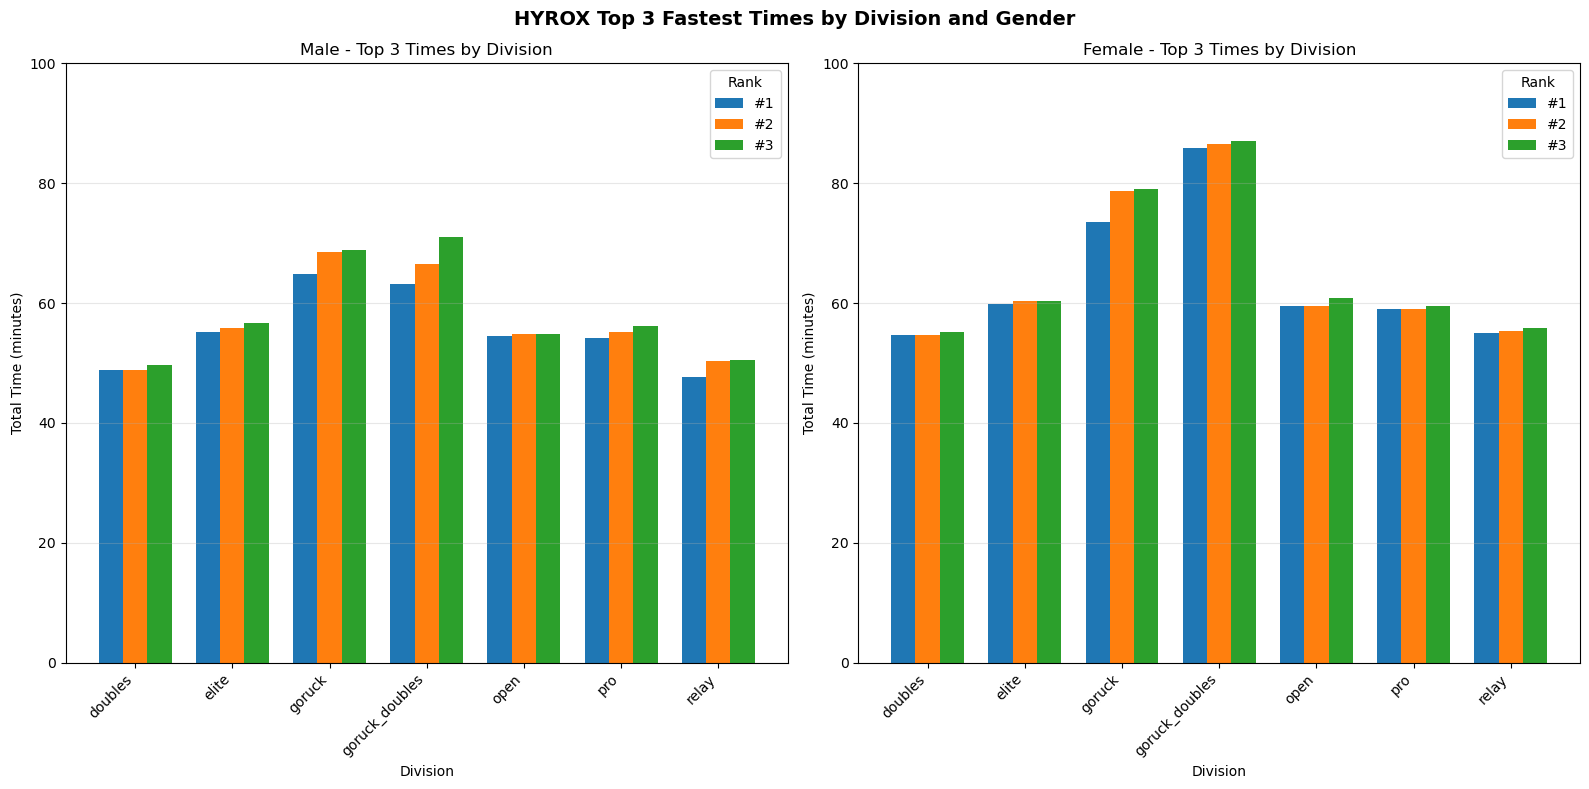

✓ Saved: top3_by_division_gender.png


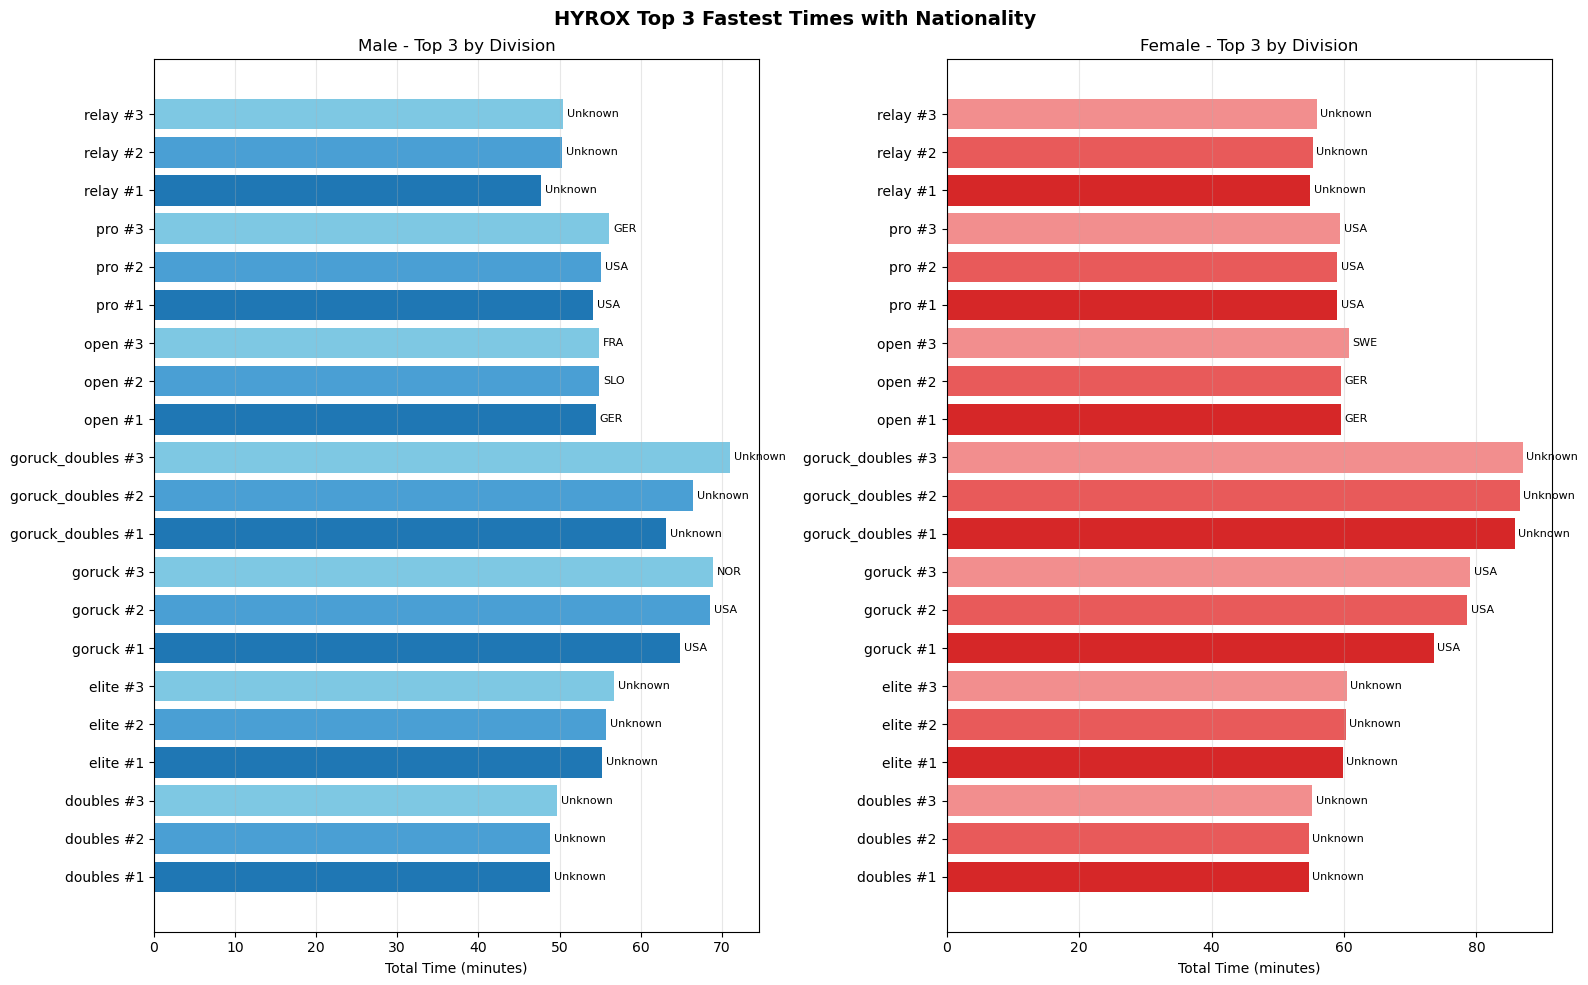

✓ Saved: top3_detailed.png


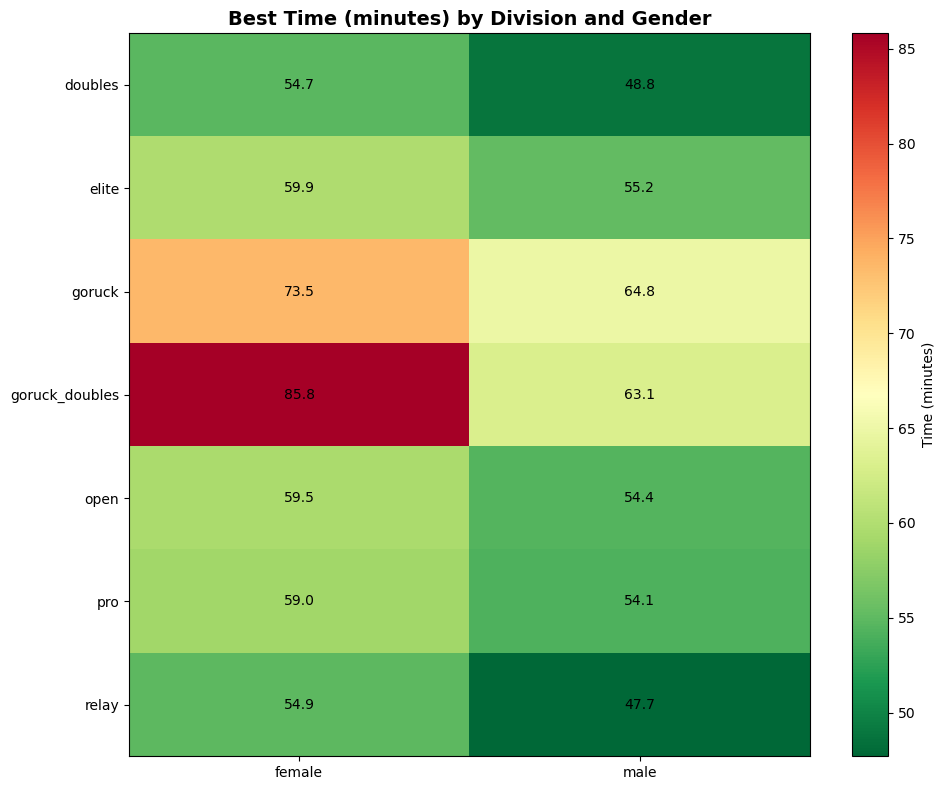

✓ Saved: best_time_heatmap.png

✓ Done! Created 3 visualizations.


In [31]:
# ============================================
# QUERY: Top 3 times by division and gender
# ============================================
pipeline = [
    {"$match": {"performance.is_valid": True}},
    {"$sort": {"performance.total_seconds": 1}},
    {"$group": {
        "_id": {
            "division": "$athlete.division",
            "gender": "$athlete.gender"
        },
        "top_3": {
            "$push": {
                "nationality": "$athlete.nationality",
                "age_group": "$athlete.age_group",
                "total_time": "$performance.total_time",
                "total_seconds": "$performance.total_seconds",
                "event": "$event.event_name"
            }
        }
    }},
    {"$project": {
        "_id": 0,
        "division": "$_id.division",
        "gender": "$_id.gender",
        "top_3": {"$slice": ["$top_3", 3]}
    }},
    {"$sort": {"division": 1, "gender": 1}}
]

results = list(collection.aggregate(pipeline))

# ============================================
# PROCESS DATA
# ============================================
data = []
for item in results:
    division = item['division']
    gender = item['gender']
    for rank, athlete in enumerate(item['top_3'], 1):
        data.append({
            'division': division,
            'gender': gender,
            'rank': rank,
            'nationality': athlete['nationality'],
            'total_time': athlete['total_time'],
            'total_minutes': athlete['total_seconds'] / 60
        })

df = pd.DataFrame(data)

print("✓ Data processed")
print(df.head(10))

# ============================================
# PLOT 1: Grouped Bar Chart - Top 3 by Division
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for idx, gender in enumerate(['male', 'female']):
    ax = axes[idx]
    df_gender = df[df['gender'] == gender]
    
    divisions = df_gender['division'].unique()
    x = np.arange(len(divisions))
    width = 0.25
    
    for rank in [1, 2, 3]:
        df_rank = df_gender[df_gender['rank'] == rank]
        # Ensure correct order by merging with divisions
        times = []
        for div in divisions:
            time_val = df_rank[df_rank['division'] == div]['total_minutes'].values
            times.append(time_val[0] if len(time_val) > 0 else 0)
        
        offset = (rank - 2) * width
        bars = ax.bar(x + offset, times, width, label=f'#{rank}')
    
    ax.set_xlabel('Division')
    ax.set_ylabel('Total Time (minutes)')
    ax.set_title(f'{gender.capitalize()} - Top 3 Times by Division')
    ax.set_xticks(x)
    ax.set_xticklabels(divisions, rotation=45, ha='right')
    ax.set_ylim(0, 100)  # SET Y-AXIS LIMIT TO 100 MINUTES
    ax.legend(title='Rank')
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('HYROX Top 3 Fastest Times by Division and Gender', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('top3_by_division_gender.png', dpi=150)
plt.show()

print("✓ Saved: top3_by_division_gender.png")

# ============================================
# PLOT 2: Horizontal Bar Chart with Labels
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

colors = {'male': ['#1f77b4', '#4a9fd4', '#7ec8e3'], 
          'female': ['#d62728', '#e85a5a', '#f28e8e']}

for idx, gender in enumerate(['male', 'female']):
    ax = axes[idx]
    df_gender = df[df['gender'] == gender].sort_values(['division', 'rank'])
    
    # Create labels with division + rank
    labels = [f"{row['division']} #{row['rank']}" for _, row in df_gender.iterrows()]
    times = df_gender['total_minutes'].values
    nationalities = df_gender['nationality'].values
    
    # Color by rank
    bar_colors = [colors[gender][row['rank']-1] for _, row in df_gender.iterrows()]
    
    bars = ax.barh(labels, times, color=bar_colors)
    
    # Add nationality labels
    for bar, nat in zip(bars, nationalities):
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                nat, va='center', fontsize=8)
    
    ax.set_xlabel('Total Time (minutes)')
    ax.set_title(f'{gender.capitalize()} - Top 3 by Division')
    ax.grid(True, alpha=0.3, axis='x')

plt.suptitle('HYROX Top 3 Fastest Times with Nationality', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('top3_detailed.png', dpi=150)
plt.show()

print("✓ Saved: top3_detailed.png")

# ============================================
# PLOT 3: Heatmap Style - Best Time per Division/Gender
# ============================================
df_best = df[df['rank'] == 1].pivot(index='division', columns='gender', values='total_minutes')

fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(df_best.values, cmap='RdYlGn_r', aspect='auto')

# Add labels
ax.set_xticks(range(len(df_best.columns)))
ax.set_yticks(range(len(df_best.index)))
ax.set_xticklabels(df_best.columns)
ax.set_yticklabels(df_best.index)

# Add values in cells
for i in range(len(df_best.index)):
    for j in range(len(df_best.columns)):
        val = df_best.iloc[i, j]
        text = ax.text(j, i, f'{val:.1f}', ha='center', va='center', fontsize=10)

plt.colorbar(im, label='Time (minutes)')
ax.set_title('Best Time (minutes) by Division and Gender', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('best_time_heatmap.png', dpi=150)
plt.show()

print("✓ Saved: best_time_heatmap.png")

print("\n✓ Done! Created 3 visualizations.")

✓ Retrieved 112 records


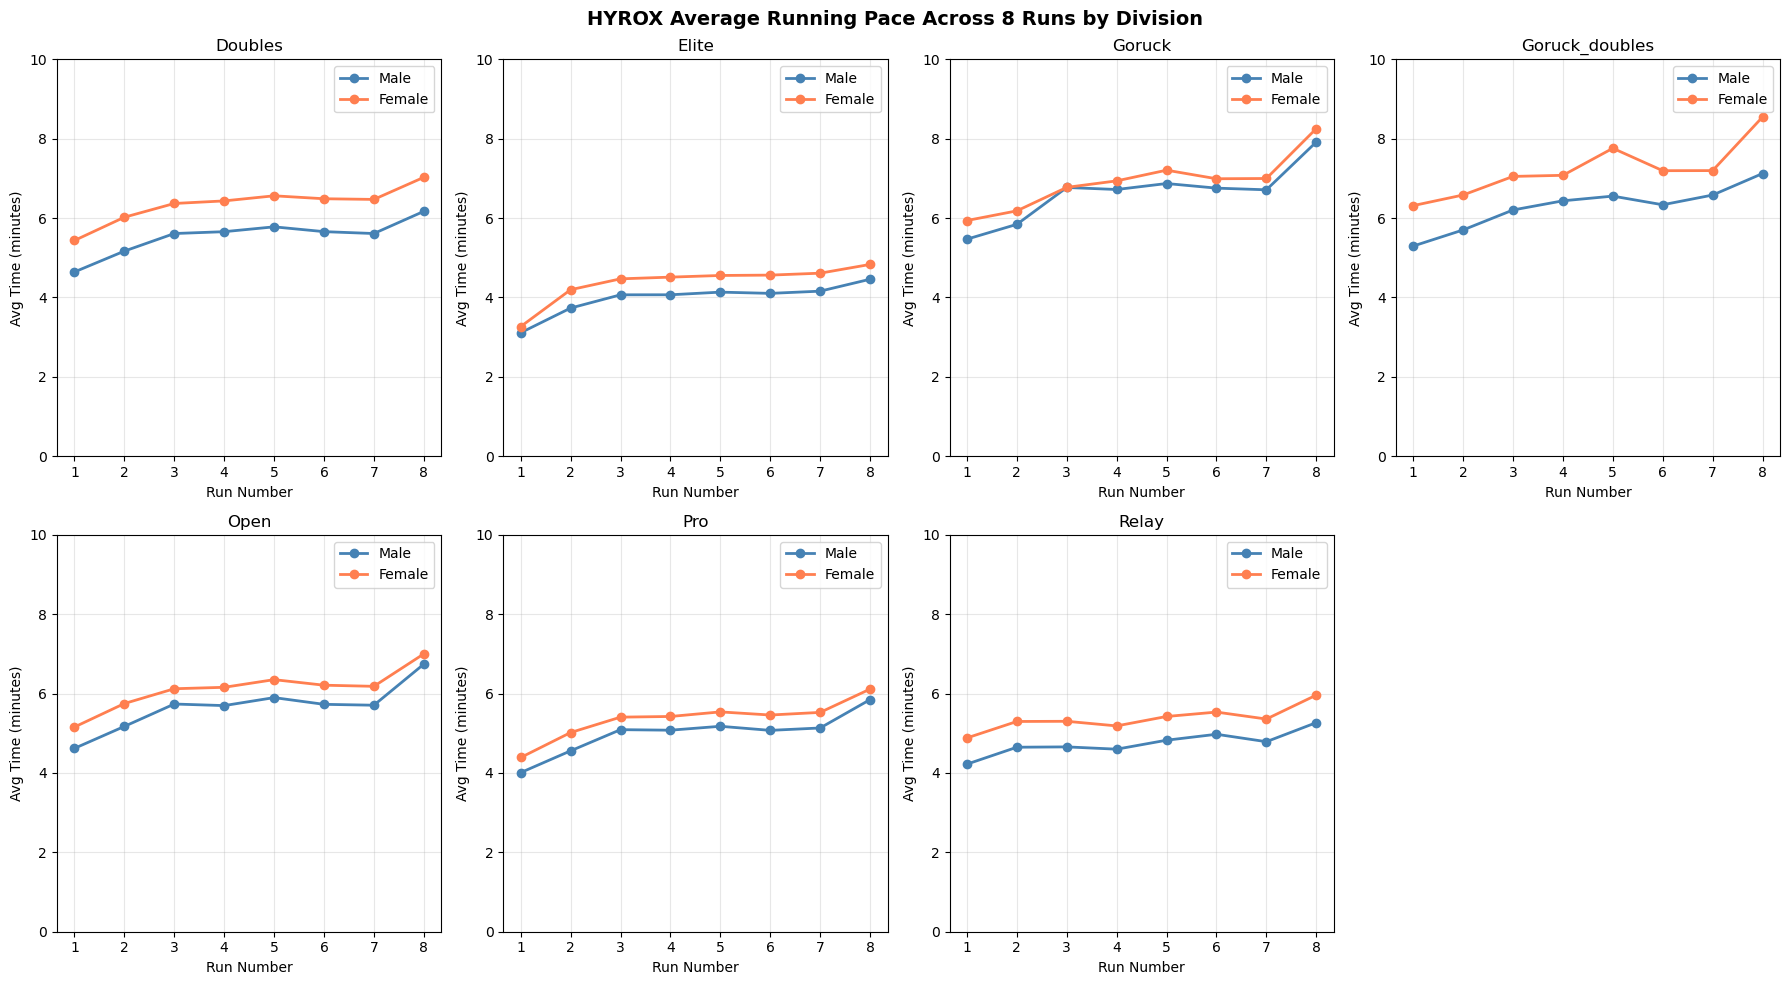

✓ Saved: run_pace_by_division.png


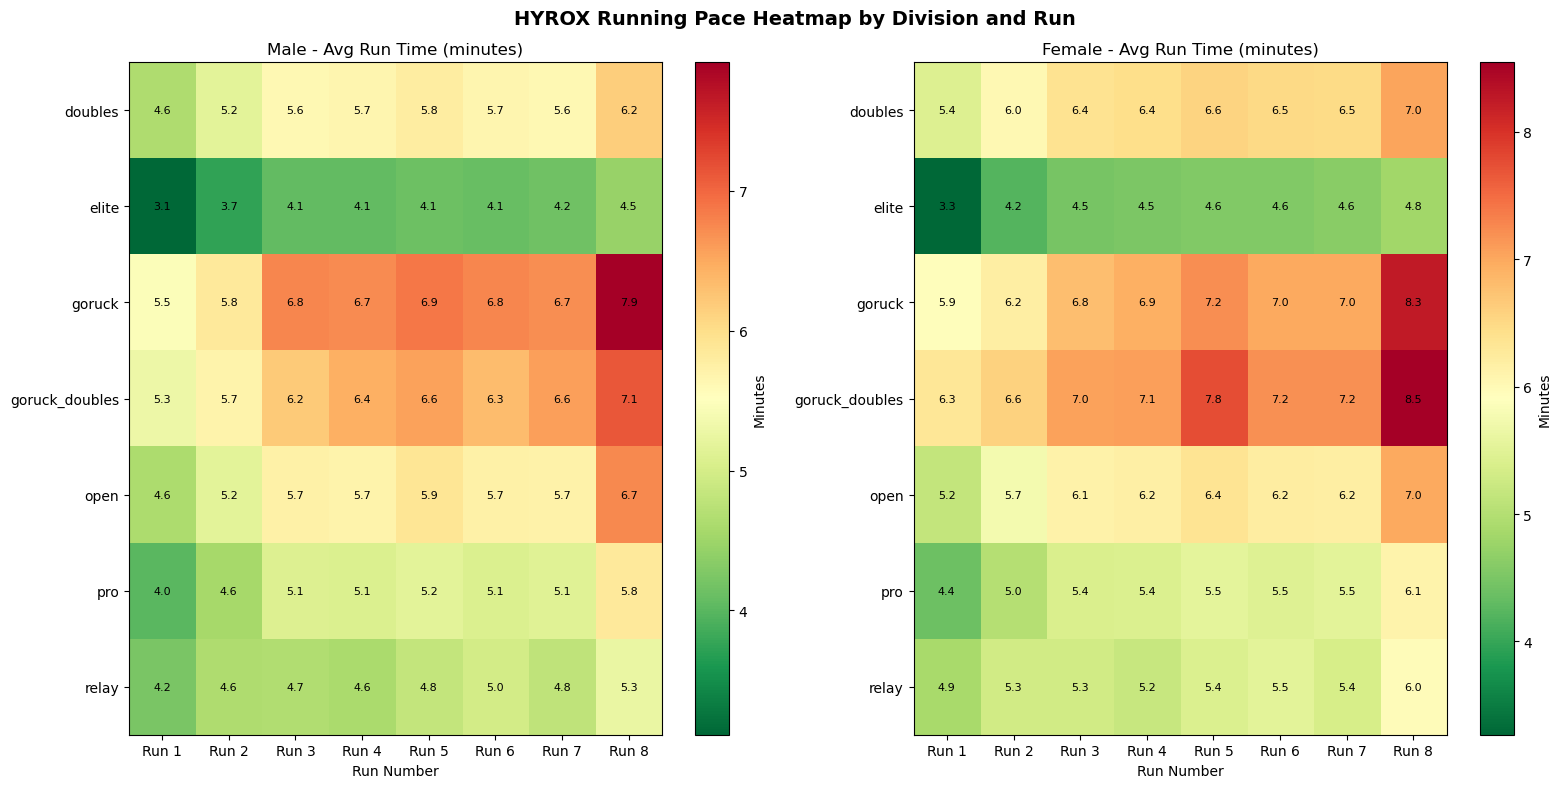

✓ Saved: run_pace_heatmap.png


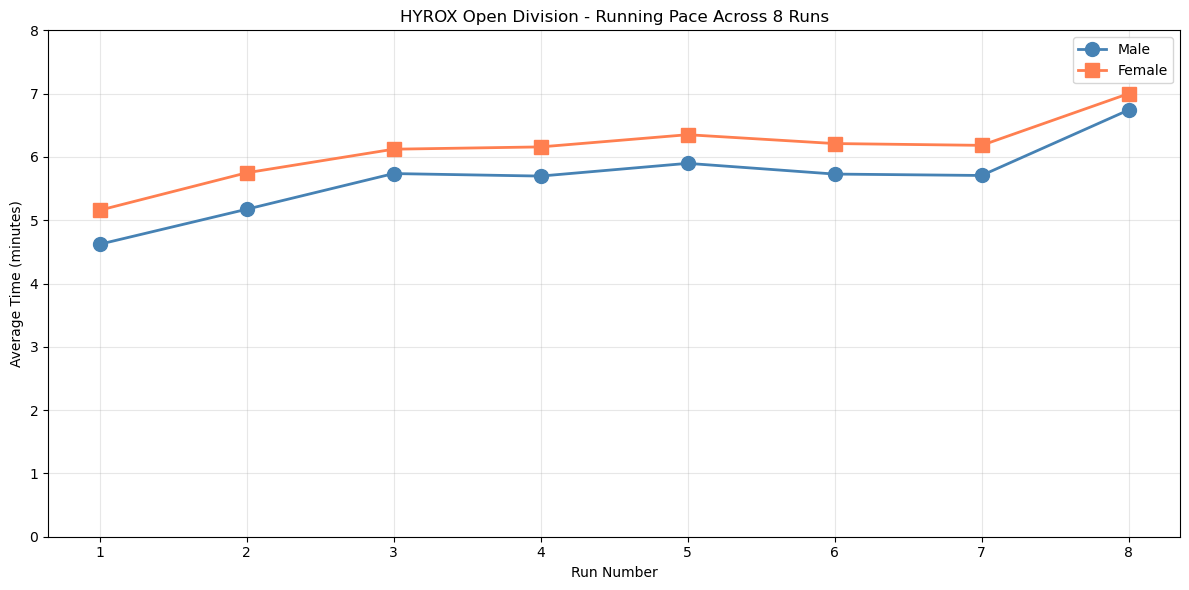

✓ Saved: run_pace_open_division.png

✓ Done! Created 3 visualizations.


In [32]:
# ============================================
# QUERY: Average run pace by division, gender, split
# ============================================
pipeline = [
    {"$match": {"performance.is_valid": True}},
    {"$unwind": "$splits"},
    {"$group": {
        "_id": {
            "division": "$athlete.division",
            "gender": "$athlete.gender",
            "split_number": "$splits.split_number"
        },
        "avg_run_seconds": {"$avg": "$splits.run_seconds"}
    }},
    {"$project": {
        "_id": 0,
        "division": "$_id.division",
        "gender": "$_id.gender",
        "run_number": "$_id.split_number",
        "avg_run_seconds": {"$round": ["$avg_run_seconds", 0]},
        "avg_run_minutes": {"$divide": ["$avg_run_seconds", 60]}
    }},
    {"$sort": {"division": 1, "gender": 1, "run_number": 1}}
]

results = list(collection.aggregate(pipeline))
df = pd.DataFrame(results)

print(f"✓ Retrieved {len(df)} records")

# ============================================
# PLOT 1: Line Chart - Pace by Division (Male vs Female)
# ============================================
divisions = df['division'].unique()

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for idx, division in enumerate(divisions):
    if idx >= 8:
        break
    ax = axes[idx]
    
    df_div = df[df['division'] == division]
    
    for gender, color in [('male', 'steelblue'), ('female', 'coral')]:
        df_gender = df_div[df_div['gender'] == gender].sort_values('run_number')
        if len(df_gender) > 0:
            ax.plot(df_gender['run_number'], df_gender['avg_run_minutes'], 
                    'o-', label=gender.capitalize(), color=color, linewidth=2, markersize=6)
    
    ax.set_xlabel('Run Number')
    ax.set_ylabel('Avg Time (minutes)')
    ax.set_title(f'{division.capitalize()}')
    ax.set_xticks(range(1, 9))
    ax.set_ylim(0, 10)  # Same scale for comparison
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(len(divisions), 8):
    axes[idx].axis('off')

plt.suptitle('HYROX Average Running Pace Across 8 Runs by Division', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('run_pace_by_division.png', dpi=150)
plt.show()

print("✓ Saved: run_pace_by_division.png")

# ============================================
# PLOT 2: Heatmap - Pace Degradation
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for idx, gender in enumerate(['male', 'female']):
    ax = axes[idx]
    
    df_gender = df[df['gender'] == gender]
    df_pivot = df_gender.pivot(index='division', columns='run_number', values='avg_run_minutes')
    
    im = ax.imshow(df_pivot.values, cmap='RdYlGn_r', aspect='auto')
    
    ax.set_xticks(range(8))
    ax.set_yticks(range(len(df_pivot.index)))
    ax.set_xticklabels([f'Run {i}' for i in range(1, 9)])
    ax.set_yticklabels(df_pivot.index)
    ax.set_xlabel('Run Number')
    ax.set_title(f'{gender.capitalize()} - Avg Run Time (minutes)')
    
    # Add values in cells
    for i in range(len(df_pivot.index)):
        for j in range(8):
            val = df_pivot.iloc[i, j]
            ax.text(j, i, f'{val:.1f}', ha='center', va='center', fontsize=8)
    
    plt.colorbar(im, ax=ax, label='Minutes')

plt.suptitle('HYROX Running Pace Heatmap by Division and Run', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('run_pace_heatmap.png', dpi=150)
plt.show()

print("✓ Saved: run_pace_heatmap.png")

# ============================================
# PLOT 3: Focus on "open" division only
# ============================================
fig, ax = plt.subplots(figsize=(12, 6))

df_open = df[df['division'] == 'open']

for gender, color, marker in [('male', 'steelblue', 'o'), ('female', 'coral', 's')]:
    df_gender = df_open[df_open['gender'] == gender].sort_values('run_number')
    ax.plot(df_gender['run_number'], df_gender['avg_run_minutes'], 
            f'{marker}-', label=gender.capitalize(), color=color, linewidth=2, markersize=10)

ax.set_xlabel('Run Number')
ax.set_ylabel('Average Time (minutes)')
ax.set_title('HYROX Open Division - Running Pace Across 8 Runs')
ax.set_xticks(range(1, 9))
ax.set_ylim(0, 8)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('run_pace_open_division.png', dpi=150)
plt.show()

print("✓ Saved: run_pace_open_division.png")

print("\n✓ Done! Created 3 visualizations.")

✓ Retrieved 112 records


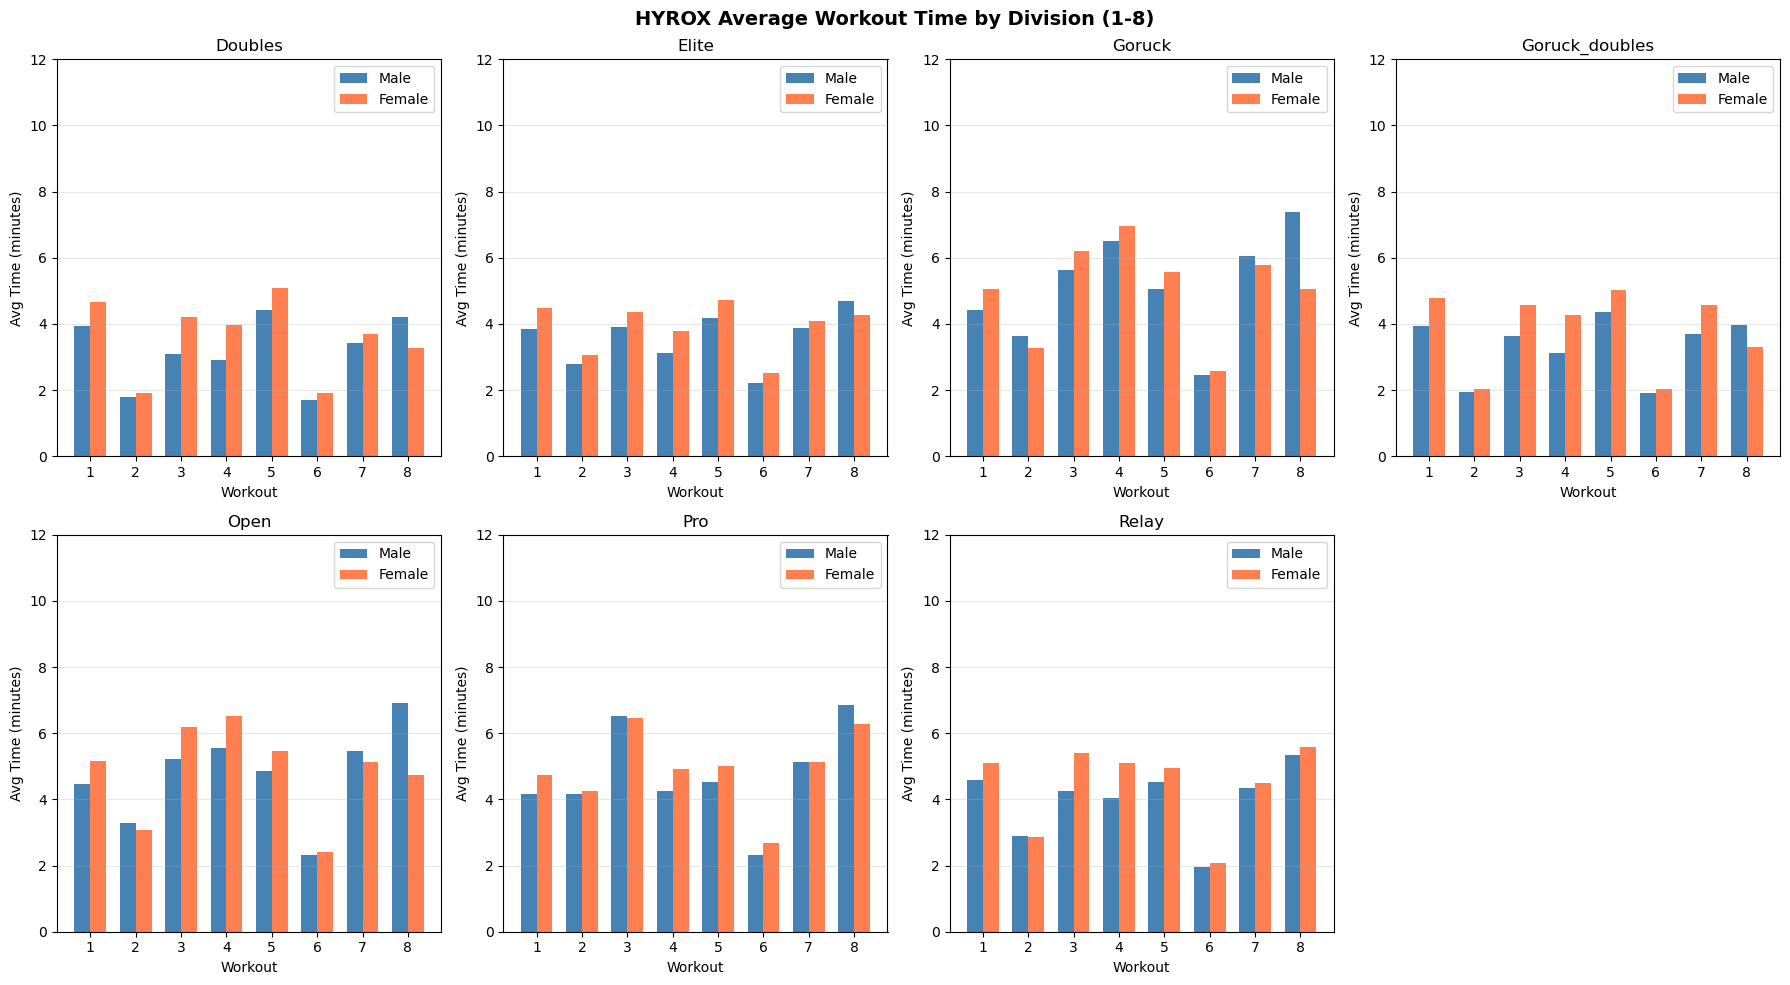

✓ Saved: workout_time_by_division.png


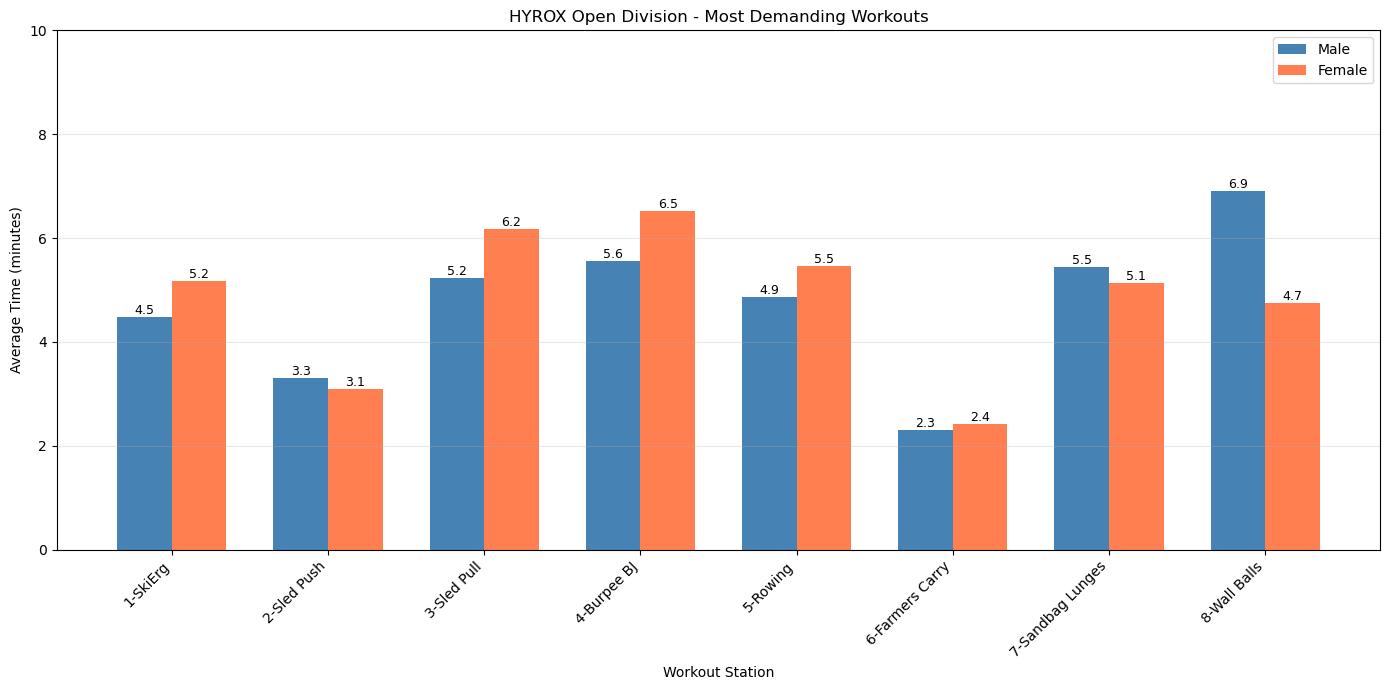

✓ Saved: workout_time_open_division.png


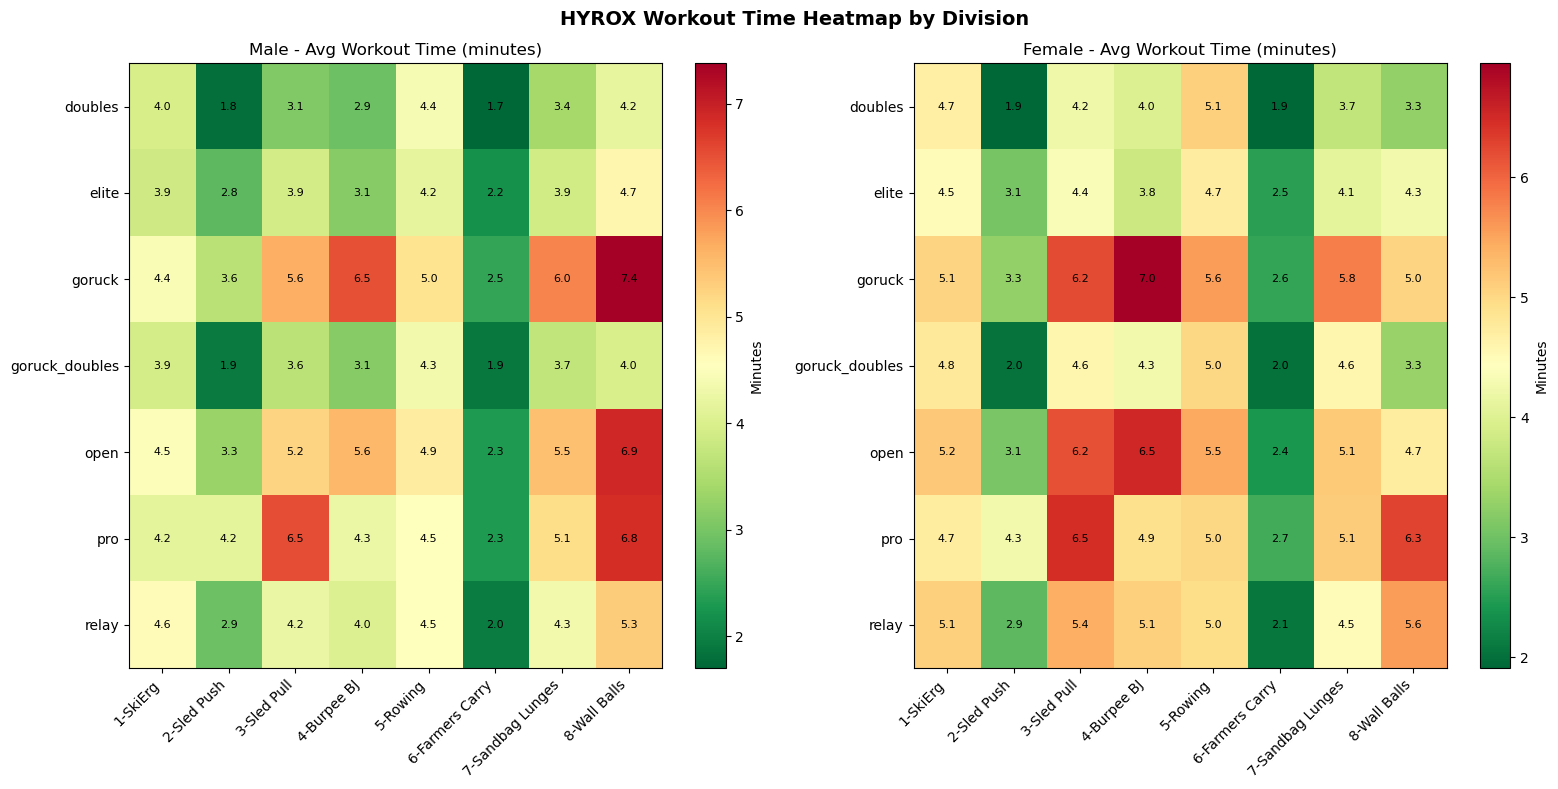

✓ Saved: workout_time_heatmap.png


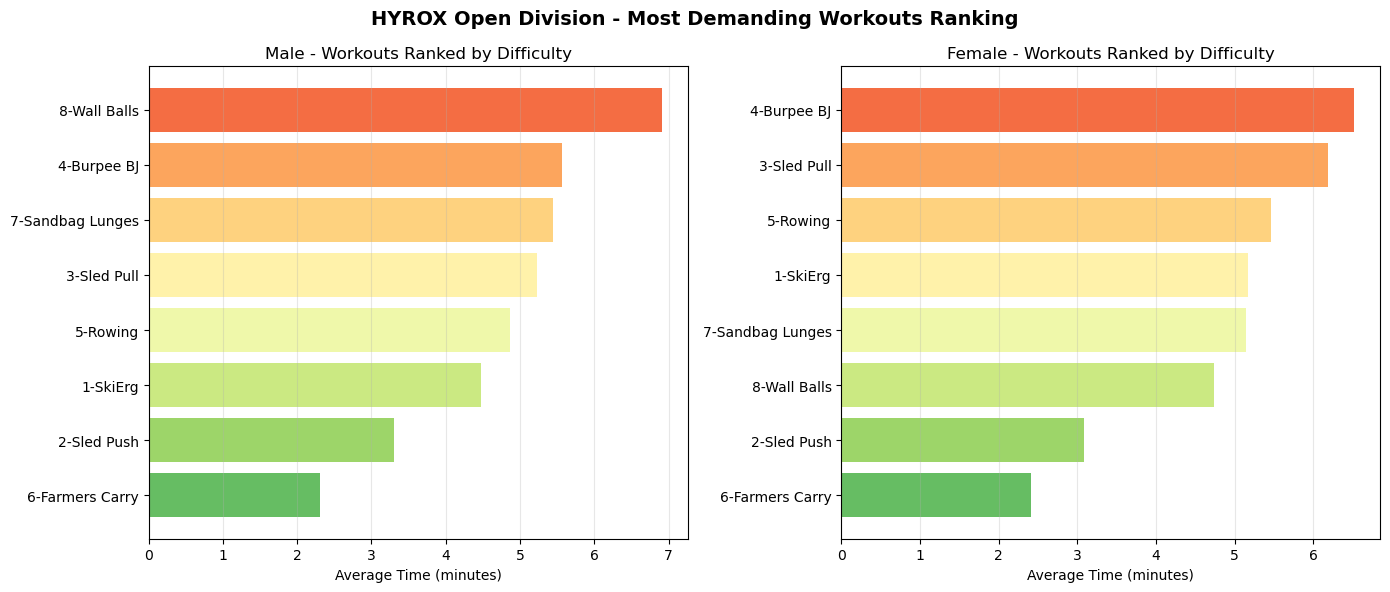

✓ Saved: workout_ranking.png

✓ Done! Created 4 visualizations.


In [33]:
# ============================================
# QUERY: Average workout time by division, gender, split
# ============================================
pipeline = [
    {"$match": {"performance.is_valid": True}},
    {"$unwind": "$splits"},
    {"$group": {
        "_id": {
            "division": "$athlete.division",
            "gender": "$athlete.gender",
            "split_number": "$splits.split_number"
        },
        "avg_workout_seconds": {"$avg": "$splits.work_seconds"}
    }},
    {"$project": {
        "_id": 0,
        "division": "$_id.division",
        "gender": "$_id.gender",
        "workout_number": "$_id.split_number",
        "avg_seconds": {"$round": ["$avg_workout_seconds", 0]},
        "avg_minutes": {"$round": [{"$divide": ["$avg_workout_seconds", 60]}, 2]}
    }},
    {"$sort": {"division": 1, "gender": 1, "workout_number": 1}}
]

results = list(collection.aggregate(pipeline))
df = pd.DataFrame(results)

print(f"✓ Retrieved {len(df)} records")

# Workout names for labels
workout_names = ['1-SkiErg', '2-Sled Push', '3-Sled Pull', '4-Burpee BJ', 
                 '5-Rowing', '6-Farmers Carry', '7-Sandbag Lunges', '8-Wall Balls']

# ============================================
# PLOT 1: Bar Chart - Workouts by Division (Male vs Female)
# ============================================
divisions = df['division'].unique()

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for idx, division in enumerate(divisions):
    if idx >= 8:
        break
    ax = axes[idx]
    
    df_div = df[df['division'] == division]
    
    x = np.arange(8)
    width = 0.35
    
    for i, (gender, color) in enumerate([('male', 'steelblue'), ('female', 'coral')]):
        df_gender = df_div[df_div['gender'] == gender].sort_values('workout_number')
        if len(df_gender) > 0:
            offset = (i - 0.5) * width
            ax.bar(x + offset, df_gender['avg_minutes'].values, width, 
                   label=gender.capitalize(), color=color)
    
    ax.set_xlabel('Workout')
    ax.set_ylabel('Avg Time (minutes)')
    ax.set_title(f'{division.capitalize()}')
    ax.set_xticks(x)
    ax.set_xticklabels([str(i) for i in range(1, 9)])
    ax.set_ylim(0, 12)  # Same scale for comparison
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

# Hide unused subplots
for idx in range(len(divisions), 8):
    axes[idx].axis('off')

plt.suptitle('HYROX Average Workout Time by Division (1-8)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('workout_time_by_division.png', dpi=150)
plt.show()

print("✓ Saved: workout_time_by_division.png")

# ============================================
# PLOT 2: Open Division Focus with Workout Names
# ============================================
fig, ax = plt.subplots(figsize=(14, 7))

df_open = df[df['division'] == 'open']

x = np.arange(8)
width = 0.35

for i, (gender, color) in enumerate([('male', 'steelblue'), ('female', 'coral')]):
    df_gender = df_open[df_open['gender'] == gender].sort_values('workout_number')
    offset = (i - 0.5) * width
    bars = ax.bar(x + offset, df_gender['avg_minutes'].values, width, 
                  label=gender.capitalize(), color=color)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Workout Station')
ax.set_ylabel('Average Time (minutes)')
ax.set_title('HYROX Open Division - Most Demanding Workouts')
ax.set_xticks(x)
ax.set_xticklabels(workout_names, rotation=45, ha='right')
ax.set_ylim(0, 10)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('workout_time_open_division.png', dpi=150)
plt.show()

print("✓ Saved: workout_time_open_division.png")

# ============================================
# PLOT 3: Heatmap - Workout Times
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for idx, gender in enumerate(['male', 'female']):
    ax = axes[idx]
    
    df_gender = df[df['gender'] == gender]
    df_pivot = df_gender.pivot(index='division', columns='workout_number', values='avg_minutes')
    
    im = ax.imshow(df_pivot.values, cmap='RdYlGn_r', aspect='auto')
    
    ax.set_xticks(range(8))
    ax.set_yticks(range(len(df_pivot.index)))
    ax.set_xticklabels(workout_names, rotation=45, ha='right')
    ax.set_yticklabels(df_pivot.index)
    ax.set_title(f'{gender.capitalize()} - Avg Workout Time (minutes)')
    
    # Add values in cells
    for i in range(len(df_pivot.index)):
        for j in range(8):
            val = df_pivot.iloc[i, j]
            ax.text(j, i, f'{val:.1f}', ha='center', va='center', fontsize=8)
    
    plt.colorbar(im, ax=ax, label='Minutes')

plt.suptitle('HYROX Workout Time Heatmap by Division', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('workout_time_heatmap.png', dpi=150)
plt.show()

print("✓ Saved: workout_time_heatmap.png")

# ============================================
# PLOT 4: Ranking - Most Demanding Workouts (Open Division)
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, gender in enumerate(['male', 'female']):
    ax = axes[idx]
    
    df_gender = df[(df['division'] == 'open') & (df['gender'] == gender)].sort_values('avg_minutes', ascending=True)
    
    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, 8))
    
    y_pos = np.arange(8)
    ax.barh(y_pos, df_gender['avg_minutes'].values, color=colors)
    
    # Add workout names
    labels = [workout_names[int(w)-1] for w in df_gender['workout_number'].values]
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Average Time (minutes)')
    ax.set_title(f'{gender.capitalize()} - Workouts Ranked by Difficulty')
    ax.grid(True, alpha=0.3, axis='x')

plt.suptitle('HYROX Open Division - Most Demanding Workouts Ranking', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('workout_ranking.png', dpi=150)
plt.show()

print("✓ Saved: workout_ranking.png")

print("\n✓ Done! Created 4 visualizations.")

✓ Retrieved 14 records
    count        division  is_championship  avg_minutes
0   26871         doubles            False        81.27
1     992         doubles             True        74.40
2      99           elite            False        68.02
3     120           elite             True        65.28
4     134          goruck            False       103.24
5      23          goruck             True        93.47
6      39  goruck_doubles            False        86.55
7       7  goruck_doubles             True        91.89
8   48884            open            False        92.03
9    1388            open             True        88.97
10  10499             pro            False        85.47
11    938             pro             True        78.98
12   1994           relay            False        81.26
13     25           relay             True        79.18


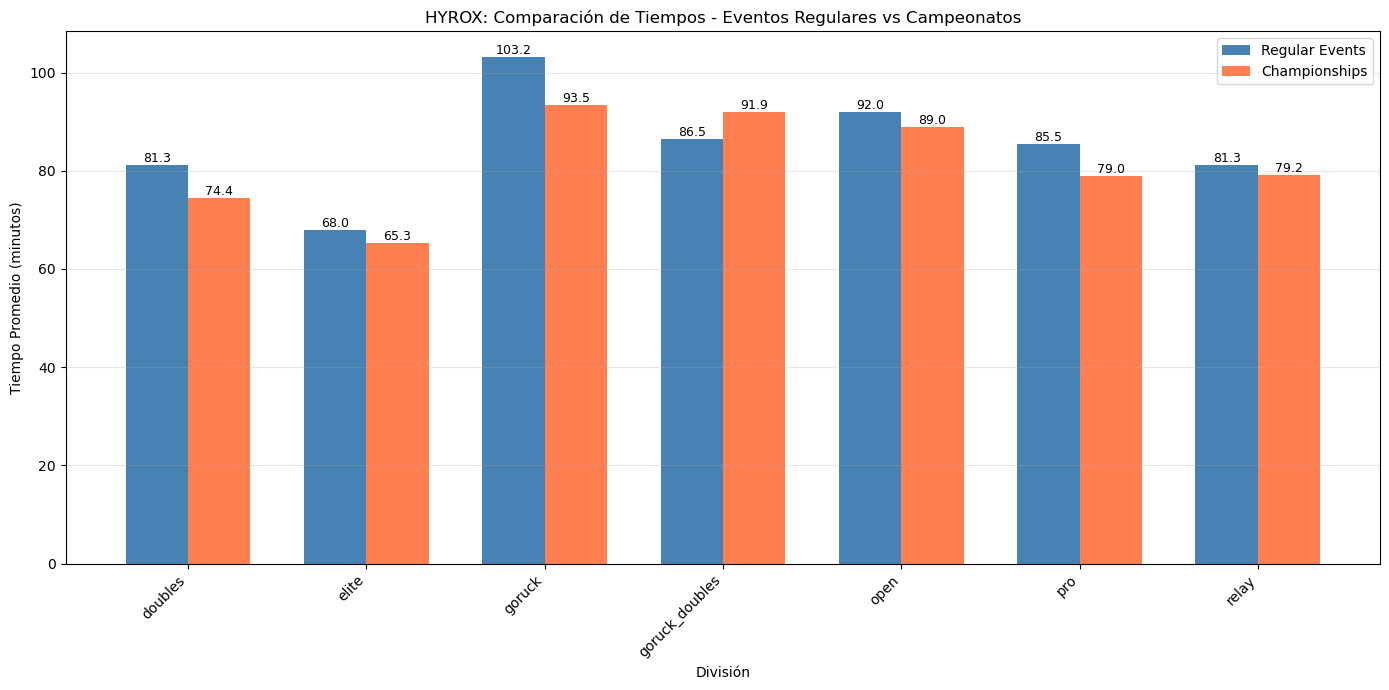

✓ Saved: championship_vs_regular.png


C:\Users\aldox\AppData\Local\Temp\ipykernel_17064\2495728223.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(divisions, rotation=45, ha='right')


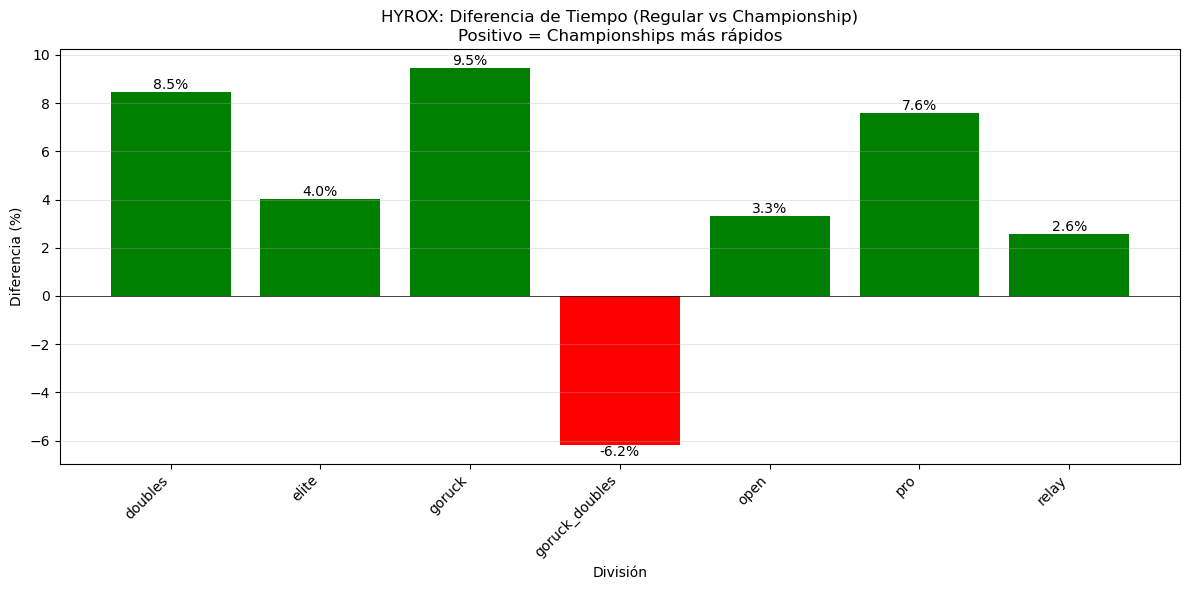

✓ Saved: championship_difference.png


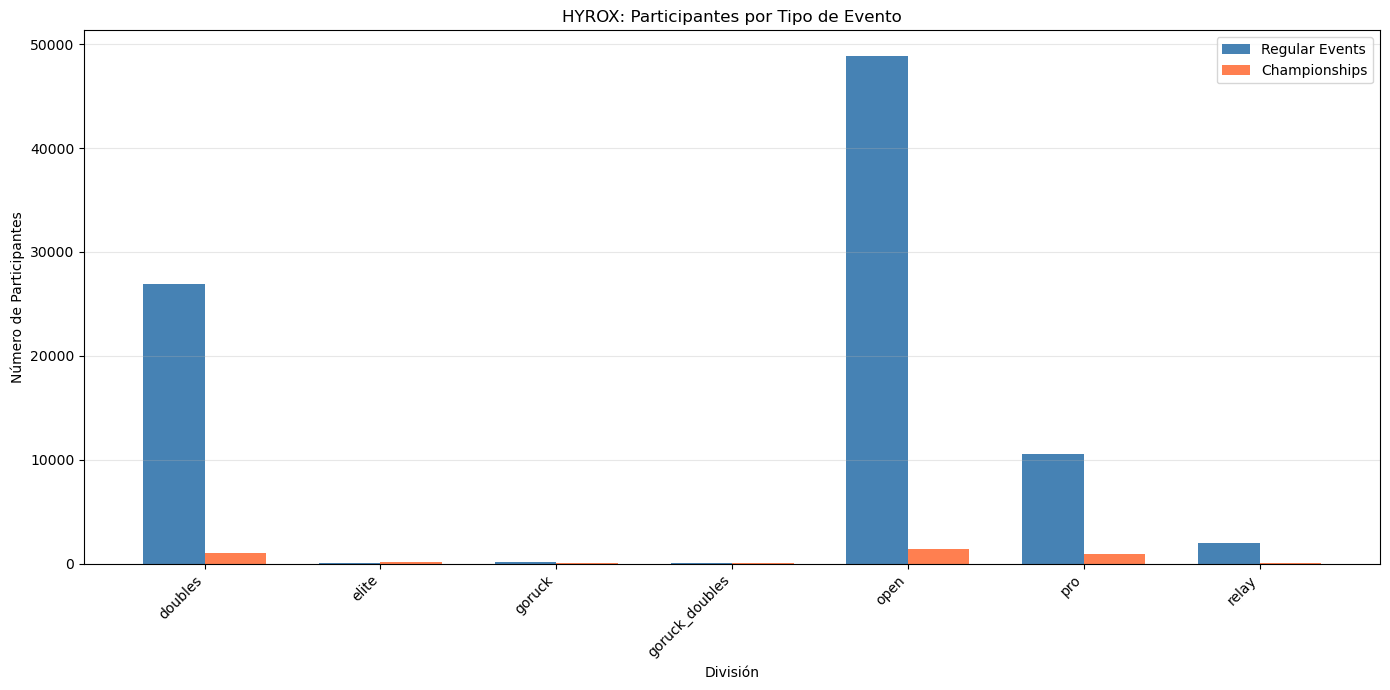

✓ Saved: participants_by_event_type.png


In [34]:
# ============================================
# QUERY: Championship vs Regular por división
# ============================================
pipeline = [
    {"$match": {"performance.is_valid": True}},
    {"$group": {
        "_id": {
            "division": "$athlete.division",
            "is_championship": "$event.is_championship"
        },
        "avg_minutes": {"$avg": {"$divide": ["$performance.total_seconds", 60]}},
        "count": {"$sum": 1}
    }},
    {"$project": {
        "_id": 0,
        "division": "$_id.division",
        "is_championship": "$_id.is_championship",
        "avg_minutes": {"$round": ["$avg_minutes", 2]},
        "count": 1
    }},
    {"$sort": {"division": 1, "is_championship": 1}}
]

results = list(collection.aggregate(pipeline))
df = pd.DataFrame(results)

print(f"✓ Retrieved {len(df)} records")
print(df)

# ============================================
# PLOT 1: Grouped Bar Chart - Championship vs Regular
# ============================================
fig, ax = plt.subplots(figsize=(14, 7))

# Prepare data
divisions = df['division'].unique()
x = np.arange(len(divisions))
width = 0.35

# Get data for each type
regular_times = []
championship_times = []

for div in divisions:
    regular = df[(df['division'] == div) & (df['is_championship'] == False)]['avg_minutes'].values
    champ = df[(df['division'] == div) & (df['is_championship'] == True)]['avg_minutes'].values
    regular_times.append(regular[0] if len(regular) > 0 else 0)
    championship_times.append(champ[0] if len(champ) > 0 else 0)

# Create bars
bars1 = ax.bar(x - width/2, regular_times, width, label='Regular Events', color='steelblue')
bars2 = ax.bar(x + width/2, championship_times, width, label='Championships', color='coral')

# Add value labels on bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=9)

add_labels(bars1)
add_labels(bars2)

ax.set_xlabel('División')
ax.set_ylabel('Tiempo Promedio (minutos)')
ax.set_title('HYROX: Comparación de Tiempos - Eventos Regulares vs Campeonatos')
ax.set_xticks(x)
ax.set_xticklabels(divisions, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('championship_vs_regular.png', dpi=150)
plt.show()

print("✓ Saved: championship_vs_regular.png")

# ============================================
# PLOT 2: Diferencia porcentual
# ============================================
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate percentage difference
diff_percent = []
for i in range(len(divisions)):
    if regular_times[i] > 0 and championship_times[i] > 0:
        diff = ((regular_times[i] - championship_times[i]) / regular_times[i]) * 100
    else:
        diff = 0
    diff_percent.append(diff)

colors = ['green' if d > 0 else 'red' for d in diff_percent]
bars = ax.bar(divisions, diff_percent, color=colors)

# Add value labels
for bar, val in zip(bars, diff_percent):
    if val != 0:
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{val:.1f}%', ha='center', va='bottom' if val > 0 else 'top', fontsize=10)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('División')
ax.set_ylabel('Diferencia (%)')
ax.set_title('HYROX: Diferencia de Tiempo (Regular vs Championship)\nPositivo = Championships más rápidos')
ax.set_xticklabels(divisions, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('championship_difference.png', dpi=150)
plt.show()

print("✓ Saved: championship_difference.png")

# ============================================
# PLOT 3: Participantes por tipo de evento
# ============================================
fig, ax = plt.subplots(figsize=(14, 7))

regular_counts = []
championship_counts = []

for div in divisions:
    regular = df[(df['division'] == div) & (df['is_championship'] == False)]['count'].values
    champ = df[(df['division'] == div) & (df['is_championship'] == True)]['count'].values
    regular_counts.append(regular[0] if len(regular) > 0 else 0)
    championship_counts.append(champ[0] if len(champ) > 0 else 0)

bars1 = ax.bar(x - width/2, regular_counts, width, label='Regular Events', color='steelblue')
bars2 = ax.bar(x + width/2, championship_counts, width, label='Championships', color='coral')

ax.set_xlabel('División')
ax.set_ylabel('Número de Participantes')
ax.set_title('HYROX: Participantes por Tipo de Evento')
ax.set_xticks(x)
ax.set_xticklabels(divisions, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('participants_by_event_type.png', dpi=150)
plt.show()

print("✓ Saved: participants_by_event_type.png")